# Toy event simulation for MST/NectarCAM

calin/examples/simulation/toy simulation.ipynb - Stephen Fegan - 2016-11-25

Copyright 2016, Stephen Fegan <sfegan@llr.in2p3.fr>
LLR, Ecole polytechnique, CNRS/IN2P3, Universite Paris-Saclay

This file is part of "__calin__". "__calin__" is free software: you can redistribute it and/or modify it under the
terms of the GNU General Public License version 2 or later, as published by
the Free Software Foundation. "__calin__" is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

## Introduction

This notebook shows how use the __calin__ interface to Geant 4 to generate sample events in NectarCAM. This is not a "true" simulation, in that it doesn't contain any simulation of the electronics, trigger, digitization etc. Particles in the air shower are generated and tracked by Geant 4 and mean Cherenkov emission at the telescope is calculated by quadratic integration in predefined steps along the charged-particle tracks and in predefined angular steps in the Cherenkov cone at each step. The test rays are traced through the MST optics onto the focal plane. Poisson and PMT fluctations can be added subsequently if desired.

The simulation contains the following elements:

1. A single MST-like telescope at the altitude of the IAC observatory, 2.147km, pointed at the zenith
2. Primary particles (gamma-rays, protons or muons) injected at the top of the atmosphere at 100km
3. Geant 4 simulation of air shower using a layered atmosphere, whose properties are read from a file (CTA Prod 3 atmospheric model number 36), and magnetic field at the IAC site, given by the World Magnetic Model
4. Quadratic integration of the mean signal in the telescope through generation of test rays on the Cherenkov cone stepped evenly along the tracks of all charged particles in air shower, controlled by parmeters *dx=10cm* and *dphi=2deg*:
   - Test rays are generated at points along tracks separated by at most:
     - *50dx* for emission heights > 100m [note cos(thetac) ~= 1/50] or 
     - *dx* for heights < 100m
   - At each point test rays are generated along the Cherenkov cone with angular steps of at most:
     - dphi
     - dx / 2 pi D tan(theta_c), where D is distance from emission point to telescope
5. Test rays are raytraced through MST assuming perfect, ideal mirror facets and shadowing by 3m x 3m square focus box
6. Weighting of test rays by
  - The Cherenkov emission formula (see equation 33.45, PDG 2016)
  - Wavelength and height dependent absorption by atmosphere using MODTRAN optical depths (atm_trans_2147_1_10_0_0_2147.dat from Prod 3)
  - Wavelength dependent effective detector efficiency combining:
    - Hamamatsu QE curve (qe_R12992-100-05.dat from Prod 3)
    - Mirror reflectivity (ref_AlSiO2HfO2.dat from Prod 3)
    - Transmission through the PMMA window (Aclylite8_tra_v2013ref.dat from Prod 3)
    - Arbitrary factor of 0.9 to account for shadowing (to be revised when shadowing is known)
  - Light-cone efficiency vs photon entry angle (CTA-LST_lightguide_eff.dat from Prod 3)
7. All PEs are summed (regardless of arrival time) to form image
8. Poisson and PMT noise, and night-sky background can be optionally added to make more realistic images

The following items (at least) are missing from the simulation:

1. Trigger
2. Conditioning of the signal by the PMT and ampifier
3. Digitization, including conversion to DC, high/low gain, saturation of the signal at 4096 DC (~700 PE?)

## 1. Import all required packages from __calin__ and ipwidgets

In [1]:
%pylab inline
import calin.math.hex_array
import calin.provenance.system_info
import calin.simulation.vs_optics
import calin.simulation.geant4_shower_generator
import calin.simulation.tracker
import calin.simulation.detector_efficiency
import calin.simulation.atmosphere
import calin.simulation.world_magnetic_model
import calin.simulation.pmt
from IPython.display import clear_output
from ipywidgets.widgets import *

Populating the interactive namespace from numpy and matplotlib


## 2. Define telescope properties for ray tracer and construct array

- Elevation : 2147m (all values are in centimeters)
- One single telescope at (0,0,2147m)
- Reflector radius : 1920cm
- Facets : 120cm side-side, on hexagonal grid with spacing of 122cm between centers
- Facet focal length : 1607cm
- Aperture : 1230cm - 5 hexaganonal rings of mirror facets with 7 facets missing
- Alignment : image at infinity focused on plane at 1600m
- Camera plane : offset for focusing of source at 10km (approx 1602.5cm)
- Camera : 9 hexagonal rings of modules, each of 7 PMTs
- Obsucration by camera box 300cm x 300cm x 150cm

In [2]:
def dms(d,m,s):
    # Note this function fails for "negative" d=0 (e.g. -00:30:00)
    sign = 1
    if(d<0):
        sign = -1
        d = abs(d)
    return sign * (d + m/60.0 + s/3600.0)

mst = calin.ix.simulation.vs_optics.IsotropicDCArrayParameters()
mst.mutable_array_origin().set_latitude(dms(28, 45, 47.36))
mst.mutable_array_origin().set_longitude(dms(-17, 53, 23.93))
mst.mutable_array_origin().set_elevation(2147 * 100.0)
scope = mst.mutable_prescribed_array_layout().add_scope_positions();
scope.set_z(mst.array_origin().elevation())
mst.mutable_reflector_frame().set_optic_axis_rotation(-90);
dc = mst.mutable_reflector()
dc.set_curvature_radius(1920)
dc.set_aperture(1230)
dc.set_facet_num_hex_rings(5)
dc.mutable_psf_align().set_object_plane(inf) # 10 * 1e5);
dc.set_alignment_image_plane(1600)
dc.set_facet_spacing(122)
dc.set_facet_size(120)
dc.set_facet_focal_length(1607)
dc.set_facet_spot_size_probability(0.8)
dc.set_facet_spot_size(0)
dc.set_facet_labeling_parity(True)
dc.set_weathering_factor(1.0)
for id in [1,62,67,72,77,82,87]: dc.add_facet_missing_list(id-1)
mst.mutable_focal_plane().set_camera_diameter(235)
mst.mutable_focal_plane().mutable_translation().set_y(1/(1.0/dc.alignment_image_plane()-1/(10 * 1e5)))
mst.mutable_pixel().set_spacing(5)
mst.mutable_pixel().set_cone_inner_diameter(5)
mst.mutable_pixel().set_cone_survival_prob(1)
mst.mutable_pixel().set_hex_module_size(1)
mst.mutable_pixel().set_module_num_hex_rings(9)
u1,v1 = calin.math.hex_array.cluster_hexid_to_center_uv(1,1)
x1,y1 = calin.math.hex_array.uv_to_xy(u1,v1)
rot = arctan2(-y1,x1)/pi*180 - 30
mst.mutable_pixel().set_grid_rotation(rot)

obs_camera_box = mst.add_obscurations()
obs_camera_box.aligned_box().max_corner().set_x(150)
obs_camera_box.aligned_box().max_corner().set_y(mst.focal_plane().translation().y()+150)
obs_camera_box.aligned_box().max_corner().set_z(150)
obs_camera_box.aligned_box().min_corner().set_x(-150)
obs_camera_box.aligned_box().min_corner().set_y(mst.focal_plane().translation().y())
obs_camera_box.aligned_box().min_corner().set_z(-150)
obs_camera_box.aligned_box().set_incoming_only(True)

rng = calin.math.rng.RNG()
cta = calin.simulation.vs_optics.VSOArray()
cta.generateFromArrayParameters(mst, rng)

cta.pointTelescopesAzEl(0,90.0/180.0*pi);

## 3. Construct detection efficiency curve, cone efficiency and atmosphere 

In [3]:
data_dir = calin.provenance.system_info.build_info().data_install_dir() + "/simulation/"
det_eff = calin.simulation.detector_efficiency.DetectionEfficiency()
det_eff.scaleEffFromFile(data_dir + 'qe_R12992-100-05.dat')
det_eff.scaleEffFromFile(data_dir + 'ref_AlSiO2HfO2.dat')
det_eff.scaleEffFromFile(data_dir + 'Aclylite8_tra_v2013ref.dat')
det_eff.scaleEffByConst(0.9)

cone_eff = calin.simulation.detector_efficiency.AngularEfficiency(data_dir + 'CTA-LST_lightguide_eff.dat')

atm = calin.simulation.atmosphere.LayeredAtmosphere(data_dir + 'atmprof36.dat')

atm_abs = calin.simulation.detector_efficiency.AtmosphericAbsorption(data_dir + 'atm_trans_2147_1_10_0_0_2147.dat')

## 4. Use world magnetic model to calculate field vs height at IAC

If you wish to have no magnetic field then uncomment the line "bfield = None"

In [4]:
wmm = calin.simulation.world_magnetic_model.WMM()
bfield = wmm.field_vs_elevation(mst.array_origin().latitude(), mst.array_origin().longitude())
#bfield = None

## 5. Construct the hierarchy of actions to take for each track

Geant 4 generates tracks and calls a "visitor" class to process each one. Here we use a hierarchy of nested "visitors", each calling down to the next one to perform the quadrature integration. We construct the hierarchy in reverse order. Going forward from Geant 4 the hierarchy is as follows:

1. Main Geant 4 class to generate the tracks
2. LengthLimitingTrackVisitor "hi" : active over whole atmosphere, this divides long tracks into segments of maximum length "50dx"
3. LengthLimitingTrackVisitor "lo" : active only within 200m of the telescope, divides long tracks into segments of maximum length "dx"
4. AirCherenkovParameterCalculatorTrackVisitor : calculate Cherenkov parameters for charged particle tracks (discard all others)
5. IACTDetectorSphereAirCherenkovTrackVisitor : calculates intersection of Cherenkov cone and series of spheres that encompass telescopes, discarding tracks that habe no intersection
6. VSO_QuadratureIACTArrayIntegrationHitVisitor : perform angular quadrature integration over Cherenkov cone, ray tracking test rays through telescope optics, discarding rays that don not hit camera
7. SimpleImagePEProcessor : make simple image of all rays that hit camera, summing weight of each ray that impacts each channel.

The integration is contolled by one parameter "dx" which defaults to 10cm, which means there will be on average more than ~100 test rays per square meter (i.e. per mirror facet) from an infinitely long track.

In [5]:
pe_imager = calin.simulation.tracker.SimpleImagePEProcessor(cta.numTelescopes(),cta.telescope(0).numPixels())

In [6]:
dx = 10.0

In [7]:
qcfg = calin.ix.simulation.tracker.QuadratureIACTArrayIntegrationConfig();
qcfg.set_ray_spacing_linear(dx)
qcfg.set_ray_spacing_angular(2)
quad = calin.simulation.tracker.VSO_QuadratureIACTArrayIntegrationHitVisitor(qcfg, cta, pe_imager)
#quad.add_trace_visitor(diag)
quad.set_detection_efficiencies(det_eff, atm_abs, cta.telescope(0).opticalAxis()[2], cone_eff)
iact = calin.simulation.tracker.IACTDetectorSphereAirCherenkovTrackVisitor(quad)
act = calin.simulation.tracker.AirCherenkovParameterCalculatorTrackVisitor(iact, atm)

In [8]:
limiter_lo = calin.simulation.tracker.LengthLimitingTrackVisitor(act, dx, 
    mst.array_origin().elevation() + 200*100)
limiter_hi = calin.simulation.tracker.LengthLimitingTrackVisitor(limiter_lo, 50.0*dx)

## 6. Track generators

Two track generators are constructed, the primary one using Geant 4 to simulate the interaction of the primary and secondary particles in the atmosphere. A second generator "StraightTrackGenerator" generates purely straight line tracks using the primary (i.e. has no physics at all) and is used here ONLY to generate "ballistic" muon tracks that do not bend in the magnetic field or generate secondart particles.

In [9]:
generator = calin.simulation.geant4_shower_generator.\
    Geant4ShowerGenerator(limiter_hi, atm, 1000, mst.array_origin().elevation(), atm.top_of_atmosphere(), bfield,
                          calin.simulation.geant4_shower_generator.VerbosityLevel_SUPRESSED_STDOUT);
generator.set_minimum_energy_cut(20);

In [10]:
ballistic_generator = calin.simulation.tracker.\
    StraightTrackGenerator(limiter_hi, mst.array_origin().elevation())

## 7. PMT and Poisson noise generators



In [11]:
pmt_cfg = calin.simulation.pmt.PMTSimPolya.cta_model_3()
pmt_cfg.set_signal_in_pe(True)
pmt = calin.simulation.pmt.PMTSimPolya(pmt_cfg,rng)
pmt_gain = mean(pmt.rvs(1000000))
noise_cfg = calin.ix.simulation.pmt.PoissonSignalSimConfig();
noise_gen = calin.simulation.pmt.PoissonSignalSim(pmt, noise_cfg, rng)

### 8. Function to run simulation and return image

In [12]:
def gen_image(theta=0, phi=0, b=70, btheta=0, e=1000, pt='proton', threshold=20, nsb=4, noise=True):
    theta *= pi/180
    phi *= pi/180
    btheta *= pi/180
    b *= 100
    e *= 1000
    u = asarray([sin(theta)*cos(phi), sin(theta)*sin(phi), -cos(theta)])
    x0 = asarray([b*cos(btheta),b*sin(btheta),mst.array_origin().elevation()])+u/u[2]*100*1e5
    if(pt=='proton'):
        pt = calin.simulation.tracker.ParticleType_PROTON
    elif(pt=='gamma'):
        pt = calin.simulation.tracker.ParticleType_GAMMA
    elif(pt=='muon'):
        pt = calin.simulation.tracker.ParticleType_MUON
    elif(pt=='muon (ballistic)'):
        pt = calin.simulation.tracker.ParticleType_MUON
        ballistic_generator.generate_showers(1, pt, e, x0, u)
        return asarray(pe.scope_image(0))
    elif(pt=='nsb'):
        return asarray(pe.scope_image(0))*0
    generator.generate_showers(1, pt, e, x0, u)
    pix_data = asarray(pe_imager.scope_image(0))
    return pix_data

## 9. Plot image using matplotlib (using a PatchCollection)

In [13]:
def plot_image(pix_data):
    s = cta.telescope(0)
#    figure(figsize=(10,8))
    figure(figsize=(7,6))
    pix = []
    idx = []
    for pix_id in range(len(pix_data)):
#        if(pix_data[pix_id] == 0.0):
#            continue
        pix_hexid = s.pixel(pix_id).hexID()
        vx,vy = calin.math.hex_array.hexid_to_vertexes_xy_trans(pix_hexid,
            s.cosPixelRotation(), s.sinPixelRotation(), s.pixelSpacing()/s.focalPlanePosition()[1]/pi*180.0)
        vv = zeros((len(vx),2))
        vv[:,0] = vx
        vv[:,1] = vy
        pix.append(Polygon(vv,closed=True))
        idx.append(pix_id)
    pc = matplotlib.collections.PatchCollection(pix, cmap=matplotlib.cm.jet)
    pc.set_array(asarray(pix_data)[idx])
    pc.set_linewidths(0)
    clo = 0
    if(min(pix_data)<0):
        clo = -5
    pc.set_clim(clo,max(80,max(pix_data)))
    gca().add_collection(pc)
    axis('square')
    axis(4.5*asarray([-1,1,-1,1]))
    xlabel('X coordinate [deg]')
    ylabel('Y coordinate [deg]')
    colorbar(pc)
    grid(color='w')

## 10. Put it all togerther : run the simulation, add noise and plot

If the directory "/CTA" exists then the image is saved as "/CTA/event.pdf"

In [14]:
def run_sim(theta=0, phi=0, b=70, btheta=0, loge=3, pt='proton', threshold=20, nsb=4.0, noise=True):
    e = 10**loge
    sim_image = gen_image(theta=theta,phi=phi,b=b,btheta=btheta,e=e,pt=pt,threshold=threshold,nsb=nsb,noise=noise)
    im = sim_image
    if(noise):
        im += nsb
        im = noise_gen.rvs(im)
        im -= noise_gen.pedestal_mean()
        im /= pmt_gain
        im -= nsb
    plot_image(im)
    text(0.025,0.975,'Energy: %s$\\,$GeV\nType: %s'%("{:,.1f}".format(e),pt),
         transform=gca().transAxes,va='top',ha='left')
    text(0.025,0.025,'$\\vec{b}$ : %g$\\,$m, %g$^\\circ$\n$\\hat{u}$ : %g$^\\circ$, %g$^\\circ$'%(b,btheta,theta,phi),
         transform=gca().transAxes,va='bottom',ha='left')
    text(0.975,0.975,'Size: %s$\\,$PE\nN(>%g$\\,$PE): %g'%("{:,.1f}".format(sum(im)), threshold, sum(im>threshold)),
         transform=gca().transAxes,va='top',ha='right')
    try:
        gcf().savefig('/CTA/event.pdf')
    except:
        pass

## 11. Set up widgets and connect them to function when button clicked

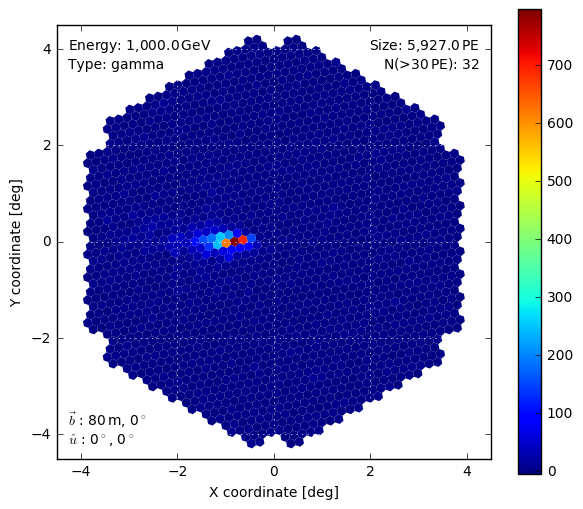

In [15]:
wb      = FloatSlider(min=0.0, max=200.0, step=0.5, value=80.0, description="Impact dist [m]")
wbtheta = FloatSlider(min=0.0, max=360.0, step=5.0, value=0.0, description="Impact angle")
wenergy = FloatSlider(min=1.0, max=5.0, step=0.1, value=3, description="Log10 E/GeV")

wtheta  = FloatSlider(min=0.0,max=8.0,step=0.1,value=0.0, description="Theta")
wphi    = FloatSlider(min=0.0, max=360.0, step=5.0, value=0.0, description="Phi")
wtype   = Dropdown(options=['gamma', 'proton', 'muon', 'muon (ballistic)', 'nsb'], 
                   value='gamma', description='Paricle type')

wnsb    = FloatSlider(min=0.0, max=20.0, step=0.2, value=4.0, description="Mean NSB")
wnoise  = Checkbox(value=True, description='')
lnoise  = Label('Add Poisson and PMT noise : ')
button  = Button(description="Run simulation")

#wbox    = VBox([HBox([wtheta,wb,wenergy]),HBox([wthresh,wtype,button])])
wbox    = VBox([HBox([wb,wbtheta,wenergy]),HBox([wtheta,wphi,wtype]),
                HBox([wnsb,HBox([lnoise,wnoise]),button])])
display(wbox)

def on_button_clicked(b):
    clear_output()
    run_sim(theta=wtheta.value, phi=wphi.value, b=wb.value, loge=wenergy.value, pt=wtype.value, 
            btheta=wbtheta.value, threshold=30, nsb=wnsb.value, noise=wnoise.value)

button.on_click(on_button_clicked)